### Celtics Play-by-play Data

I took this game ID from the [Celtics 2017 Game-by-game notebook](Celtics 2017 Game-by-game.ipynb).

In [1]:
from nba_api.stats.endpoints import playbyplayv2

In [2]:
game_id = '0021701219'
pbp = playbyplayv2.PlayByPlayV2(game_id)
pbp = pbp.get_data_frames()[0]
pbp.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION
0,0021701219,2,12,0,1,8:11 PM,12:00,None,None,None,...,None,None,None,0,0,None,NaN,None,None,None
1,0021701219,4,10,0,1,8:11 PM,12:00,Jump Ball Baynes vs. Allen: Tip to Larkin,None,None,...,Brooklyn,Nets,BKN,4,203499,Shane Larkin,1.610613e+09,Boston,Celtics,BOS
2,0021701219,7,2,1,1,8:11 PM,11:47,MISS Baynes 16' Jump Shot,None,None,...,None,None,None,0,0,None,NaN,None,None,None
3,0021701219,8,4,0,1,8:11 PM,11:42,None,None,Allen REBOUND (Off:0 Def:1),...,None,None,None,0,0,None,NaN,None,None,None
4,0021701219,9,2,79,1,8:12 PM,11:23,None,None,MISS Russell 15' Pullup Jump Shot,...,None,None,None,0,0,None,NaN,None,None,None


One thing I'd like is for the scores to be filled in fully.
Right now, the scores are only populated in rows where there is a score change:

In [3]:
pbp.head(20)[['HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'SCORE']]

,HOMEDESCRIPTION,VISITORDESCRIPTION,SCORE
0,None,None,None
1,Jump Ball Baynes vs. Allen: Tip to Larkin,None,None
2,MISS Baynes 16' Jump Shot,None,None
3,None,Allen REBOUND (Off:0 Def:1),None
4,None,MISS Russell 15' Pullup Jump Shot,None
5,Yabusele REBOUND (Off:0 Def:1),None,None
6,MISS Baynes 16' Jump Shot,None,None
7,None,Hollis-Jefferson REBOUND (Off:0 Def:1),None
8,None,Allen 6' Hook Shot (2 PTS) (Hollis-Jefferson 1...,2 - 0
9,MISS Nader 8' Driving Layup,None,None


Let's fix that by filling forward.

In [4]:
# The first fillna fills forward, but doesn't know what to do with the
# first few nulls (no values to propagate yet). The second filla takes
# care of those, with a 0 - 0 score.
pbp['SCORE'] = pbp.SCORE.fillna(method='ffill').fillna('0 - 0')
pbp.head(12)[['HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'SCORE']]

,HOMEDESCRIPTION,VISITORDESCRIPTION,SCORE
0,None,None,0 - 0
1,Jump Ball Baynes vs. Allen: Tip to Larkin,None,0 - 0
2,MISS Baynes 16' Jump Shot,None,0 - 0
3,None,Allen REBOUND (Off:0 Def:1),0 - 0
4,None,MISS Russell 15' Pullup Jump Shot,0 - 0
5,Yabusele REBOUND (Off:0 Def:1),None,0 - 0
6,MISS Baynes 16' Jump Shot,None,0 - 0
7,None,Hollis-Jefferson REBOUND (Off:0 Def:1),0 - 0
8,None,Allen 6' Hook Shot (2 PTS) (Hollis-Jefferson 1...,2 - 0
9,MISS Nader 8' Driving Layup,None,2 - 0


Next, the SCORE column has both teams' scores, which is (obviously) not very good.
Let's split it out.

In [5]:
split_scores = pbp.SCORE.str.split(' - ')
away_scores = split_scores.apply(lambda scores: scores[0] if scores is not None else None)
home_scores = split_scores.apply(lambda scores: scores[1] if scores is not None else None)
pbp['HOME_SCORE'] = home_scores
pbp['AWAY_SCORE'] = away_scores

In [6]:
pbp.tail(4)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,HOME_SCORE,AWAY_SCORE
453,0021701219,637,5,10,4,10:08 PM,0:23,CELTICS Turnover: 8 Second Violation (T#14),None,None,...,None,1,0,None,NaN,None,None,None,110,97
454,0021701219,634,2,1,4,10:08 PM,0:18,None,None,MISS Stauskas 27' 3PT Jump Shot,...,None,0,0,None,NaN,None,None,None,110,97
455,0021701219,635,4,0,4,10:08 PM,0:16,Yabusele REBOUND (Off:2 Def:3),None,None,...,None,0,0,None,NaN,None,None,None,110,97
456,0021701219,636,13,0,4,10:09 PM,0:00,None,None,None,...,None,0,0,None,NaN,None,None,None,110,97


I verified that these are the correct home and away scores.

Also helpful would be a timer that started at 0:00 at the beginning of the game and kept track of the total time elapsed.

In [7]:
from datetime import timedelta
import pandas as pd

def make_elapsed_time(row):
    # Based on the period (quarter), how much time must already have passed?
    # Need to account for the first 4 being 12 minute but overtimes being 5.
    pd = int(row.PERIOD)
    regular_pds = min(4, pd) - 1
    ot_pds = max(pd - 4, 0)
    time_beginning = timedelta(minutes=(12 * regular_pds) + (5 * ot_pds))
    # Calculate the elapsed time in the current period.
    max_min = timedelta(minutes=12 if row.PERIOD <= 4 else 5)
    remaining_min, remaining_sec = row.PCTIMESTRING.split(':')
    remaining_time = timedelta(minutes=int(remaining_min),
                               seconds=int(remaining_sec))
    elapsed_in_pd = max_min - remaining_time
    # Add these together and return as strings.
    elapsed = time_beginning + elapsed_in_pd
    elapsed_min = elapsed.seconds // 60
    elapsed_sec = elapsed.seconds %  60
    return elapsed_min, elapsed_sec
   
# Sorry this is so weird. Splitting a series into 2 columns isn't pretty.
elapsed_time = pbp.apply(make_elapsed_time, axis=1)
pbp['ELAPSED_MIN'] = elapsed_time.str[0]
pbp['ELAPSED_SEC'] = elapsed_time.str[1]
pbp.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,HOME_SCORE,AWAY_SCORE,ELAPSED_MIN,ELAPSED_SEC
0,0021701219,2,12,0,1,8:11 PM,12:00,None,None,None,...,0,None,NaN,None,None,None,0,0,0,0
1,0021701219,4,10,0,1,8:11 PM,12:00,Jump Ball Baynes vs. Allen: Tip to Larkin,None,None,...,203499,Shane Larkin,1.610613e+09,Boston,Celtics,BOS,0,0,0,0
2,0021701219,7,2,1,1,8:11 PM,11:47,MISS Baynes 16' Jump Shot,None,None,...,0,None,NaN,None,None,None,0,0,0,13
3,0021701219,8,4,0,1,8:11 PM,11:42,None,None,Allen REBOUND (Off:0 Def:1),...,0,None,NaN,None,None,None,0,0,0,18
4,0021701219,9,2,79,1,8:12 PM,11:23,None,None,MISS Russell 15' Pullup Jump Shot,...,0,None,NaN,None,None,None,0,0,0,37


Let's make sure it looks right.

In [8]:
pbp[['PERIOD', 'PCTIMESTRING', 'ELAPSED_MIN', 'ELAPSED_SEC']].head()

,PERIOD,PCTIMESTRING,ELAPSED_MIN,ELAPSED_SEC
0,1,12:00,0,0
1,1,12:00,0,0
2,1,11:47,0,13
3,1,11:42,0,18
4,1,11:23,0,37


In [9]:
pbp[['PERIOD', 'PCTIMESTRING', 'ELAPSED_MIN', 'ELAPSED_SEC']].tail()

,PERIOD,PCTIMESTRING,ELAPSED_MIN,ELAPSED_SEC
452,4,0:39,47,21
453,4,0:23,47,37
454,4,0:18,47,42
455,4,0:16,47,44
456,4,0:00,48,0


This process of pulling a game as a DataFrame, filling scores, adding home/away score columns, and creating an elapsed time function seems likely to come up often... so functions.

In [10]:
def get_game(game_id):
    # Pull the data.
    pbp = playbyplayv2.PlayByPlayV2(game_id)
    pbp = pbp.get_data_frames()[0]
    # Fill forward scores.
    pbp['SCORE'] = pbp.SCORE.fillna(method='ffill').fillna('0 - 0')
    # Add home- and away-score columns.
    split_scores = pbp.SCORE.str.split(' - ')
    away_scores = split_scores.apply(lambda scores: scores[0] if scores is not None else None)
    home_scores = split_scores.apply(lambda scores: scores[1] if scores is not None else None)
    pbp['HOME_SCORE'] = home_scores
    pbp['AWAY_SCORE'] = away_scores
    # Add the elapsed time column.
    elapsed_time = pbp.apply(make_elapsed_time, axis=1)
    pbp['ELAPSED_MIN'] = elapsed_time.str[0]
    pbp['ELAPSED_SEC'] = elapsed_time.str[1]
    # A total elapsed time as a string.
    pbp['ELAPSED_TIME_STR'] = (pbp.ELAPSED_MIN.astype(str).str.zfill(2) + ':'
                                + pbp.ELAPSED_SEC.astype(str).str.zfill(2))
    return pbp

In [11]:
pbp = get_game(game_id)
pbp.tail(5)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,HOME_SCORE,AWAY_SCORE,ELAPSED_MIN,ELAPSED_SEC,ELAPSED_TIME_STR
452,0021701219,630,1,50,4,10:07 PM,0:39,None,None,Webb III Running Dunk (2 PTS) (Doyle 5 AST),...,None,NaN,None,None,None,110,97,47,21,47:21
453,0021701219,637,5,10,4,10:08 PM,0:23,CELTICS Turnover: 8 Second Violation (T#14),None,None,...,None,NaN,None,None,None,110,97,47,37,47:37
454,0021701219,634,2,1,4,10:08 PM,0:18,None,None,MISS Stauskas 27' 3PT Jump Shot,...,None,NaN,None,None,None,110,97,47,42,47:42
455,0021701219,635,4,0,4,10:08 PM,0:16,Yabusele REBOUND (Off:2 Def:3),None,None,...,None,NaN,None,None,None,110,97,47,44,47:44
456,0021701219,636,13,0,4,10:09 PM,0:00,None,None,None,...,None,NaN,None,None,None,110,97,48,0,48:00


Plot some score changes.

In [12]:
import altair as alt

In [13]:
# For plots, we'll want a total elapsed seconds column to be the x-axis
pbp['TOTAL_ELAPSED_SEC'] = (pbp.ELAPSED_MIN * 60) + pbp.ELAPSED_SEC

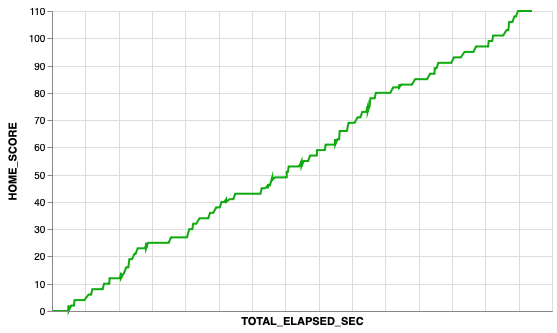

In [14]:
alt.Chart(pbp, width=500).mark_line().encode(
    x=alt.X('TOTAL_ELAPSED_SEC:Q', axis=alt.Axis(labels=False, ticks=False)),
    y='HOME_SCORE:Q',
    color=alt.ColorValue('#11AA11')
)

You could definitely quibble with this chart; the times are spaced evenly apart, instead of proportionate to the time between them.
But for now it's close enough.

To plot both teams' scores, we need to do some quick reshaping.

In [15]:
melted = pbp.melt(id_vars=['TOTAL_ELAPSED_SEC', 'EVENTNUM'], value_vars=['HOME_SCORE', 'AWAY_SCORE'],
                  var_name='HOME/AWAY', value_name='POINTS')
melted.head()

,TOTAL_ELAPSED_SEC,EVENTNUM,HOME/AWAY,POINTS
0,0,2,HOME_SCORE,0
1,0,4,HOME_SCORE,0
2,13,7,HOME_SCORE,0
3,18,8,HOME_SCORE,0
4,37,9,HOME_SCORE,0


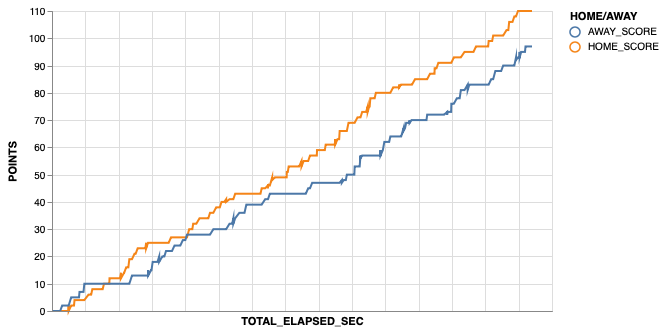

In [16]:
alt.Chart(melted, width=500).mark_line().encode(
    x=alt.X('TOTAL_ELAPSED_SEC', axis=alt.Axis(labels=False, ticks=False)),
    y='POINTS:Q',
    color='HOME/AWAY'
)

Let's clean it up a little.

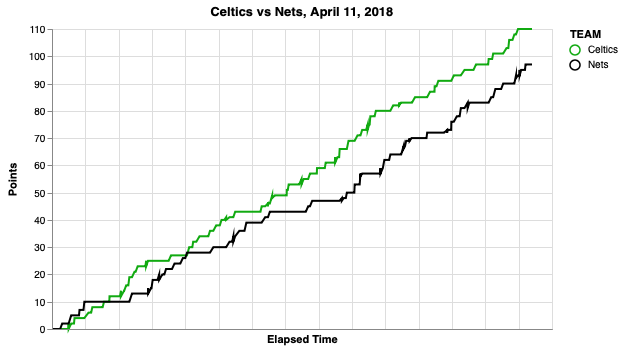

In [17]:
melted['TEAM'] = melted['HOME/AWAY'].apply(lambda x: 'Celtics' if x == 'HOME_SCORE' else 'Nets')

nice_chart = alt.Chart(melted, width=500).mark_line().encode(
    x=alt.X('TOTAL_ELAPSED_SEC', axis=alt.Axis(title='Elapsed Time',
                                               labels=False, ticks=False)),
    y=alt.Y('POINTS:Q', axis=alt.Axis(title='Points')),
    color=alt.Color('TEAM', scale=alt.Scale(domain=['Celtics', 'Nets'],
                                                 range=['#11AA11', 'black']))
).properties(title='Celtics vs Nets, April 11, 2018')

nice_chart

You can see that from 5 minutes on, the Celtics were ahead basically the whole game.

Let's highlight plays that were made by Semi Ojeleye.

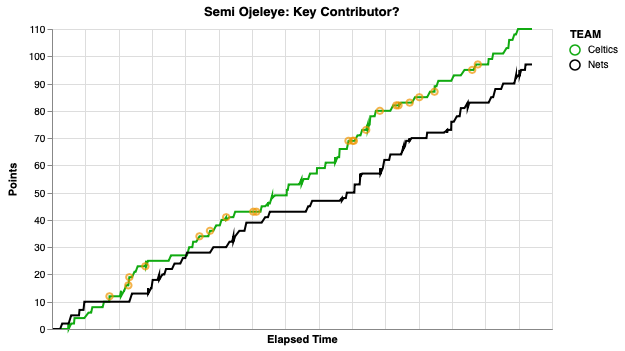

In [19]:
oj_pbp = pbp[pbp.HOMEDESCRIPTION.notnull() & pbp.HOMEDESCRIPTION.str.contains('Ojeleye')]
oj = alt.Chart(oj_pbp).mark_point().encode(
    x=alt.X('TOTAL_ELAPSED_SEC', axis=alt.Axis(labels=False, ticks=False)),
    y='HOME_SCORE:Q',
    color=alt.ColorValue('#EF9500'),
    size=alt.SizeValue('40')
)
(nice_chart + oj).properties(title='Semi Ojeleye: Key Contributor?')